In [ ]:
import ollama
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re

# ---------------------------
# 1. Parse file into list of texts
# ---------------------------
def parse_text_blocks(path):
    """
    Parse a file of the form:
    Index: xxxx
    Keys: ...
    Text: ...
    Question: ...
    
    Returns list of text passages (Text + Question).
    """
    with open(path, "r", encoding="utf-8") as f:
        content = f.read()

    # Split into blocks starting with "Index:"
    blocks = re.split(r"Index:\s*\d+", content)
    passages = []
    for block in blocks:
        if not block.strip():
            continue
        # Extract Text and Question
        text_match = re.search(r"Text:\s*(.*?)(?=Question:)", block, re.S)
        question_match = re.search(r"Question:\s*(.*)", block, re.S)
        if text_match:
            text = text_match.group(1).strip()
            question = question_match.group(1).strip() if question_match else ""
            passages.append(text + " " + question)
    return passages

# ---------------------------
# 2. Get embeddings with Ollama
# ---------------------------
def get_embeddings(texts, model="nomic-embed-text"):
    embeddings = []
    for t in texts:
        response = ollama.embeddings(model=model, prompt=t)
        embeddings.append(response["embedding"])
    return np.array(embeddings)

# ---------------------------
# 3. Scoring function
# ---------------------------
def compute_scores(embeddings, awareness_anchor, integration_anchor, alpha=0.5, beta=0.5):
    embeddings = np.array(embeddings)
    awareness = np.mean(cosine_similarity(embeddings, awareness_anchor.reshape(1, -1)))
    integration = np.mean(cosine_similarity(embeddings, integration_anchor.reshape(1, -1)))
    overall = alpha * awareness + beta * integration
    return {
        "awareness": float(awareness),
        "integration": float(integration),
        "overall": float(overall)
    }

# ---------------------------
# 4. Load data + anchors
# ---------------------------
aristotle_texts = parse_text_blocks("Free_Will_ARISTOTLE.txt")
machiavelli_texts = parse_text_blocks("Free_Will_MACHIAVELLI.txt")

awareness_anchor = np.load("anchors/awareness.npy")
integration_anchor = np.load("anchors/integration.npy")

# ---------------------------
# 5. Generate embeddings
# ---------------------------
aristotle_embeddings = get_embeddings(aristotle_texts)
machiavelli_embeddings = get_embeddings(machiavelli_texts)

# ---------------------------
# 6. Compute scores
# ---------------------------
scores_aristotle = compute_scores(aristotle_embeddings, awareness_anchor, integration_anchor)
scores_combined = compute_scores(
    np.vstack([aristotle_embeddings, machiavelli_embeddings]),
    awareness_anchor,
    integration_anchor
)

print("Aristotle only:", scores_aristotle)
print("Aristotle + Machiavelli:", scores_combined)


Aristotle only: {'awareness': 0.4430455322424402, 'integration': 0.47304952228705627, 'overall': 0.45804752726474823}
Aristotle + Machiavelli: {'awareness': 0.42243266705592036, 'integration': 0.446141703441785, 'overall': 0.4342871852488527}


In [23]:
# ---------------------------
# 1. Load Nietzsche text
# ---------------------------
nietzsche_texts = parse_text_blocks("Free_Will_NIETZSCHE.txt")  # same format as Aristotle/Machiavelli files

# ---------------------------
# 2. Generate embeddings
# ---------------------------
nietzsche_embeddings = get_embeddings(nietzsche_texts)

# ---------------------------
# 3. Combine embeddings for comparisons
# ---------------------------

# Aristotle only
scores_aristotle = compute_scores(aristotle_embeddings, awareness_anchor, integration_anchor)

# Aristotle + Machiavelli
scores_aristotle_machiavelli = compute_scores(
    np.vstack([aristotle_embeddings, machiavelli_embeddings]),
    awareness_anchor,
    integration_anchor
)

# Aristotle + Machiavelli + Nietzsche
scores_all_three = compute_scores(
    np.vstack([aristotle_embeddings, machiavelli_embeddings, nietzsche_embeddings]),
    awareness_anchor,
    integration_anchor
)

scores_aristotle_nietzsche = compute_scores(np.vstack([aristotle_embeddings, nietzsche_embeddings]), awareness_anchor, integration_anchor)
scores_nietzsche = compute_scores(nietzsche_embeddings, awareness_anchor, integration_anchor)
scores_machiavelli = compute_scores(machiavelli_embeddings, awareness_anchor, integration_anchor)

# ---------------------------
# 4. Print results
# ---------------------------
print("Aristotle only:", scores_aristotle)
print("Aristotle + Machiavelli:", scores_aristotle_machiavelli)
print("Aristotle + Machiavelli + Nietzsche:", scores_all_three)
print("Aristotle + Nietzsche:", scores_aristotle_nietzsche)
print("Nietzsche only:", scores_nietzsche)
print("Machiabelli only:", scores_machiavelli)


Aristotle only: {'awareness': 0.4430455322424402, 'integration': 0.47304952228705627, 'overall': 0.45804752726474823}
Aristotle + Machiavelli: {'awareness': 0.42243266705592036, 'integration': 0.446141703441785, 'overall': 0.4342871852488527}
Aristotle + Machiavelli + Nietzsche: {'awareness': 0.42376722912066345, 'integration': 0.44558282525197984, 'overall': 0.43467502718632167}
Aristotle + Nietzsche: {'awareness': 0.4402277995591105, 'integration': 0.4653445307435793, 'overall': 0.4527861651513449}
Nietzsche only: {'awareness': 0.43177460150912184, 'integration': 0.4422295561131484, 'overall': 0.4370020788111351}
Machiabelli only: {'awareness': 0.4018198018694004, 'integration': 0.41923388459651384, 'overall': 0.41052684323295713}


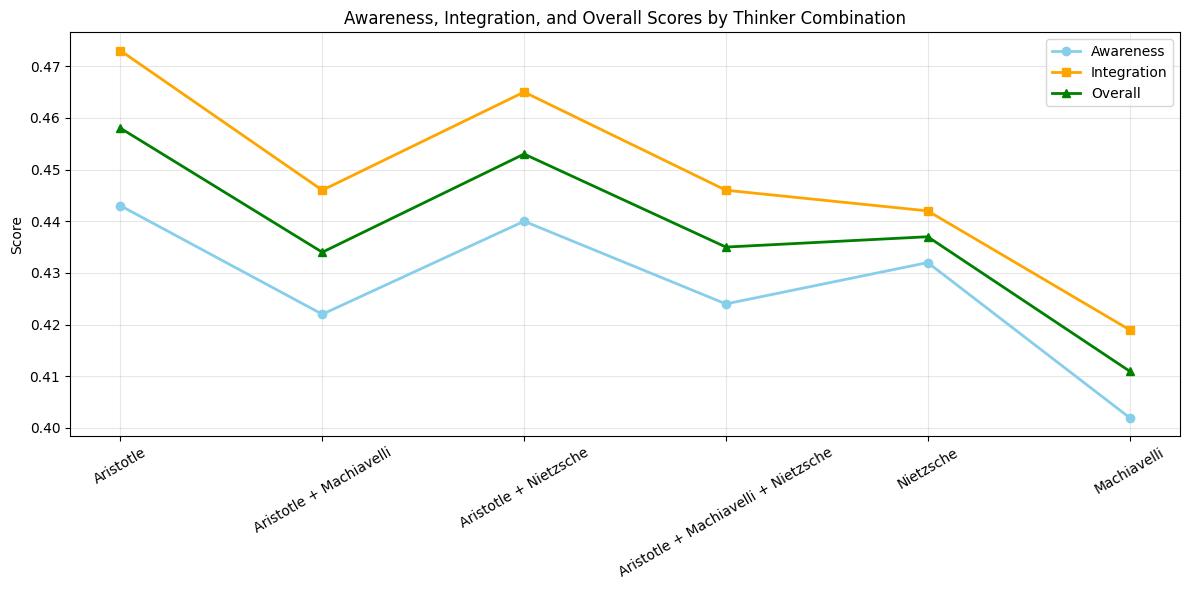

In [24]:
import matplotlib.pyplot as plt

# Labels for each combination
labels = [
    "Aristotle",
    "Aristotle + Machiavelli",
    "Aristotle + Nietzsche",
    "Aristotle + Machiavelli + Nietzsche",
    "Nietzsche",
    "Machiavelli"
]

# Corresponding scores
awareness_scores = [
    0.443, 0.422, 0.440, 0.424, 0.432, 0.402
]
integration_scores = [
    0.473, 0.446, 0.465, 0.446, 0.442, 0.419
]
overall_scores = [
    0.458, 0.434, 0.453, 0.435, 0.437, 0.411
]

x = range(len(labels))

plt.figure(figsize=(12,6))
plt.plot(x, awareness_scores, marker='o', label='Awareness', color='skyblue', linewidth=2)
plt.plot(x, integration_scores, marker='s', label='Integration', color='orange', linewidth=2)
plt.plot(x, overall_scores, marker='^', label='Overall', color='green', linewidth=2)

plt.xticks(x, labels, rotation=30)
plt.ylabel("Score")
plt.title("Awareness, Integration, and Overall Scores by Thinker Combination")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
